In [1]:
import numpy as np
import pandas as pd
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer

## Load the data and apply preprocessing


In [2]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
ratings = pd.read_csv(ratings_file)
movies_file = movielens_dir / "movies.csv"
movies = pd.read_csv(movies_file)

In [3]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

## Prepare training and validation data


In [6]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90752, 2), (10084, 2), (90752,), (10084,))

In [7]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot, Add, Activation, Lambda
from tensorflow.keras.layers import Embedding, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [9]:
batch_size = 64
epochs = 25
l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 64
learning_rate = 0.25

if batch_size % num_microbatches != 0:
    raise ValueError('Batch size should be an integer multiple of the number of microbatches')

In [10]:
optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate)

loss = tf.keras.losses.mean_squared_error

In [11]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [12]:
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [13]:
model = RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        30500       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        486200      input_2[0][0]                    
_______________________________________________________________________________________

In [14]:
history = model.fit(x=X_train_array, y=y_train, batch_size=batch_size, epochs=5, verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
  14/1418 [..............................] - ETA: 5s - loss: 1.0350

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1418/1418 [==============================] - 6s 4ms/step - loss: 0.9300 - val_loss: 0.8360
Epoch 2/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.8314 - val_loss: 0.8052
Epoch 3/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.7995 - val_loss: 0.7988
Epoch 4/5
1418/1418 [==============================] - 6s 4ms/step - loss: 0.7815 - val_loss: 0.7952
Epoch 5/5
1418/1418 [==============================] - 5s 4ms/step - loss: 0.7748 - val_loss: 0.7837


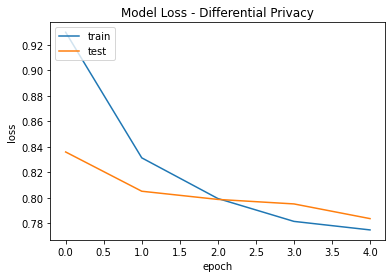

In [15]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss - Differential Privacy")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [16]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=len(X_train), batch_size=64, noise_multiplier=1.3, epochs=15, delta=1e-5)

DP-SGD with sampling rate = 0.0705% and noise_multiplier = 1.3 iterated over 21270 steps satisfies differential privacy with eps = 0.623 and delta = 1e-05.
The optimal RDP order is 23.0.


(0.6230580289692322, 23.0)

In [17]:
user_ids = ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = ratings["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
ratings["user"] = ratings["userId"].map(user2user_encoded)
ratings["movie"] = ratings["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
ratings["rating"] = ratings["rating"].values.astype(np.float32)

In [18]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

user_id = ratings.userId.sample(1).iloc[0]
movies_watched_by_user = ratings[ratings.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
user_pred_array = [user_movie_array[:, 0], user_movie_array[:, 1]]
ratings = model.predict(user_pred_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 474
Movies with high ratings from user
--------------------------------
Enchanted April (1992) : Drama|Romance
Strictly Ballroom (1992) : Comedy|Romance
Moonstruck (1987) : Comedy|Romance
Safety Last! (1923) : Action|Comedy|Romance
Harry Potter and the Goblet of Fire (2005) : Adventure|Fantasy|Thriller|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Walking Dead, The (1995) : Drama|War
Substitute, The (1996) : Action|Crime|Drama
Frighteners, The (1996) : Comedy|Horror|Thriller
Road Warrior, The (Mad Max 2) (1981) : Action|Adventure|Sci-Fi|Thriller
Signal, The (2007) : Horror|Sci-Fi|Thriller
Definitely, Maybe (2008) : Comedy|Drama|Romance
Spiral (2007) : Drama|Horror|Thriller
House Bunny, The (2008) : Comedy
Up in the Air (2009) : Drama|Romance
Love and Other Drugs (2010) : Comedy|Drama|Romance


In [19]:
# tf.keras.utils.plot_model(
#     model,
#     to_file="model.png",
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=96,
# )

In [20]:
result_dict = {
    'Approach': ['Without noise', 'Noise scale 0.5', 'Noise scale 1.0', 'Noise scale 1.5', 'Noise scale 2.0', 'Differential Privacy'],
    'Train_Loss': [0.6072, 0.6208, 0.6409, 0.6568, 0.6672, 0.7748],
    'Valid_Loss': [0.6135, 0.6250, 0.6454, 0.6636, 0.6817, 0.7837]
}
result = pd.DataFrame(result_dict, index=range(1,7))
result

,Approach,Train_Loss,Valid_Loss
1,Without noise,0.6072,0.6135
2,Noise scale 0.5,0.6208,0.6250
3,Noise scale 1.0,0.6409,0.6454
4,Noise scale 1.5,0.6568,0.6636
5,Noise scale 2,0.6672,0.6817
6,Differential Privacy,0.7748,0.7837


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

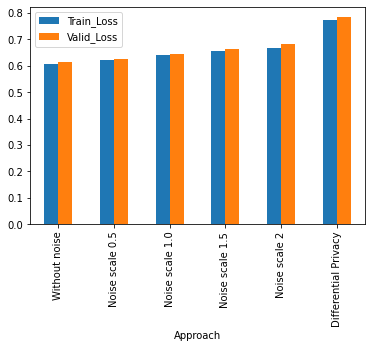

In [21]:
result.plot(x='Approach', kind='bar')
plt.xticks(rotation=90)

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 <a list of 8 Text major ticklabel objects>)

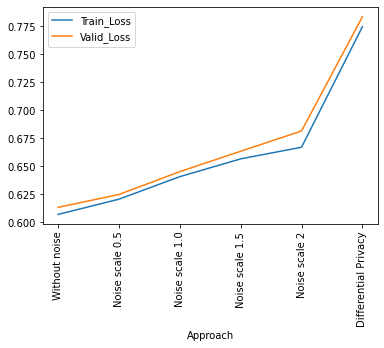

In [22]:
result.plot(x='Approach', kind='line')
plt.xticks(rotation=90)